In [1]:
#pip install opencv-python
#pip install cmake
#pip install dlib

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

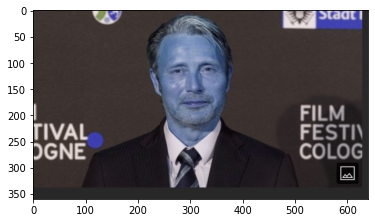

In [3]:
import os
my_image_path = os.getenv("HOME") + "/aiffel/camera_sticker/images/image.png"
img_bgr = cv2.imread(my_image_path)
img_bgr = cv2.resize(img_bgr, (640,360))
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

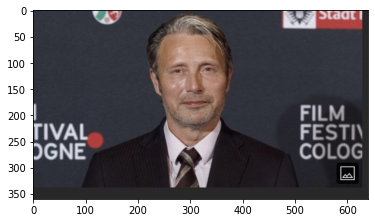

In [4]:
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()


In [6]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(239, 82) (368, 211)]]


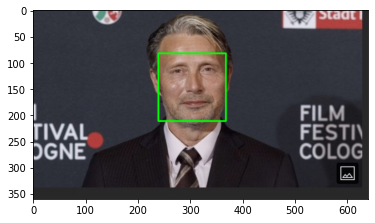

In [7]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t),(r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()

In [8]:
import os
model_path = os.getenv("HOME") + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


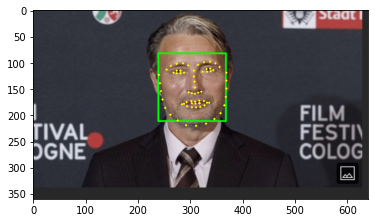

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,255,255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)    
plt.imshow(img_show_rgb)
plt.show()

In [11]:
# index 2, 36, 48, 3

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[33])  # nose center index 30
    x = landmark[33][0]
    y = landmark[33][1] + 7
    w = (landmark[33][0] - landmark[2][0]) * 2
    h = (landmark[33][1] - landmark[30][1]) * 2
    print('(x,y): (%d,%d)'%(x,y))
    print('(w,h): (%d,%d)'%(w,h))

(309, 159)
(x,y): (309,166)
(w,h): (130,24)


(24, 130, 3)


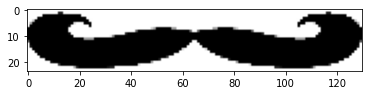

In [12]:
import os
sticker_path = os.getenv("HOME") + '/aiffel/camera_sticker/images/mustache.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = img_sticker[180:330]
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)

In [13]:
sticker_area = img_show[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
img_show[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = \
    np.where(img_sticker==0, img_sticker, sticker_area).astype(np.uint8)

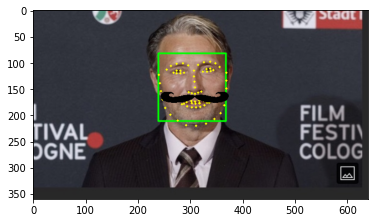

In [14]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

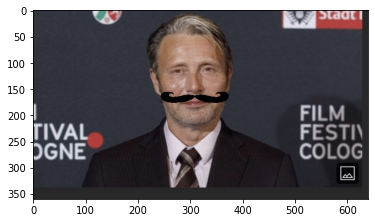

In [15]:
sticker_area = img_bgr[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]
img_bgr[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()